### Grammy 

Import the libreries and modules

In [1]:
import os
import re
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

###  DB connection 

To access the dataset stored in a PostgreSQL database, we first need to establish a connection. We are going to read the data from the table named "grammy" in the PostgreSQL database.

In [2]:
load_dotenv()

try:
    db_uri = f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"

    engine = create_engine(db_uri)
    query = "SELECT * FROM public.grammy;"

    df = pd.read_sql_query(query, engine)
    print("Table data read correctly in a Pandas DataFrame")

except Exception as e:
    print("Error reading data from table:", e)

finally:
    
    if engine is not None:
        engine.dispose()
        print("Closed SQLAlchemy engine connection")

Table data read correctly in a Pandas DataFrame
Closed SQLAlchemy engine connection


### Analysis of the dataset 

Once we have read the data from the "grammy" table into a DataFrame (df), we can get an overview of the data by using functions like head() to display the first few rows of the DataFrame

In [3]:
df.head()

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


We use this method to get a quick overview of the structure and types of data in our DataFrame. This allows us to identify potential problems such as missing values or inconsistencies in data types, which is crucial for making informed decisions about data cleaning and transformation, ensuring the reliability of our downstream analysis.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          4810 non-null   int64 
 1   title         4810 non-null   object
 2   published_at  4810 non-null   object
 3   updated_at    4810 non-null   object
 4   category      4810 non-null   object
 5   nominee       4804 non-null   object
 6   artist        2970 non-null   object
 7   workers       2620 non-null   object
 8   img           3443 non-null   object
 9   winner        4810 non-null   bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 343.0+ KB


We have a dataset consisting of 4810 records and 10 columns.

In [5]:
df.shape

(4810, 10)

In [6]:
df.columns

Index(['year', 'title', 'published_at', 'updated_at', 'category', 'nominee',
       'artist', 'workers', 'img', 'winner'],
      dtype='object')

Column descriptions:

- **year**: Year associated with the record.
  
- **title**: Title of the record.

- **published_at**: Date and time of publication of the record.

- **updated_at**: Date and time of the last update of the record.

- **category**: Category to which the record belongs.

- **nominee**: Name of the nominee associated with the record.

- **artist**: Name of the artist associated with the record.

- **workers**: List of workers associated with the record.

- **image**: URL or path of the image associated with the record.

- **winner**: Boolean indicator representing whether the record is a winner (True) or not (False).


### Check null values

The "grammy" dataset shows the following in terms of null values:

- Most entries have a nominee, with only 6 missing values.

- A significant number of null values in the artist (1840 values) and workers (2190 values) columns, indicating that information about artists and people involved may be incomplete in many records.

- A considerable number of entries do not have an associated image (img), with 1367 null values in this column.

These missing data may impact the analysis and should be properly addressed during processing and interpretation of the results.

In [7]:
df.isnull().sum()

year               0
title              0
published_at       0
updated_at         0
category           0
nominee            6
artist          1840
workers         2190
img             1367
winner             0
dtype: int64

These unique values provide insight into the diversity and breadth of the data set in terms of years, titles, categories, nominees, artists and other attributes related to the Grammy Awards.

In [8]:
df.nunique()

year              62
title             62
published_at       4
updated_at        10
category         638
nominee         4131
artist          1658
workers         2366
img             1463
winner             1
dtype: int64

### Artist

We begin the analysis by focusing on the "artists" column.

In [9]:
df["artist"].unique()

array(['Billie Eilish', 'Bon Iver', 'Ariana Grande', ..., 'The Champs',
       'Stan Freberg',
       'David Seville And The Chipmunks (Ross Bagdasarian, Sr.)'],
      dtype=object)

We note that the information in the "workers" column could be useful to fill in the null values in other fields.

In [10]:
df['workers'].unique()

array(["Finneas O'Connell, producer; Rob Kinelski & Finneas O'Connell, engineers/mixers; John Greenham, mastering engineer",
       'BJ Burton, Brad Cook, Chris Messina & Justin Vernon, producers; BJ Burton, Zach Hanson & Chris Messina, engineers/mixers; Greg Calbi, mastering engineer',
       'Charles Anderson, Tommy Brown, Michael Foster & Victoria Monet, producers; Serban Ghenea, John Hanes, Billy Hickey & Brendan Morawski, engineers/mixers; Randy Merrill, mastering engineer',
       ..., 'Andres Segovia, artist',
       'Hollywood String Quartet (Alvin Dinkin, Paul Shure, Eleanor Aller Slatkin & Felix Slatkin), artists',
       'Roger Wagner, choir director'], dtype=object)

We note that the null values in the "artist" column can be completed using the information contained in the "workers" column, where we find additional details about the artists within parentheses.

In [11]:
df.loc[df['artist'].isnull() & ~df['workers'].isnull(), ['artist', 'workers']].head()

,artist,workers
16,None,"Billie Eilish O'Connell & Finneas O'Connell, s..."
17,None,"Natalie Hemby, Lady Gaga, Hillary Lindsey & Lo..."
18,None,"Brandi Carlile, Phil Hanseroth, Tim Hanseroth ..."
19,None,"Ruby Amanfu, Sam Ashworth, D. Arcelious Harris..."
20,None,"Taylor Swift, songwriter (Taylor Swift)"


### Transformation of content between workers' brackets 

We perform a transformation where the information in parentheses in the "workers" column is used to replace the null values in the "artists" column.

In [12]:
pattern = r'\(([^)]+)\)'

content_within_parentheses = df['workers'].str.extract(pattern)

df['artist'] = df['artist'].fillna(content_within_parentheses[0])

We checked how the number of null values in the "artist" column was reduced after performing the transformation.

In [13]:
df.isnull().sum()

year               0
title              0
published_at       0
updated_at         0
category           0
nominee            6
artist           474
workers         2190
img             1367
winner             0
dtype: int64

### Transformation of artist - workers 

We note that the information contained in the "workers" column can be used to replace null values in the "artist" column, and vice versa, to improve data integrity.

In [14]:
filled_artist = df['artist'].fillna(df['workers'])
filled_workers = df['workers'].fillna(df['artist'])

df['artist'] = filled_artist
df['workers'] = filled_workers

We verify that the number of null values in both the "workers" column and the "artist" column has decreased after performing the transformation.

In [15]:
df.isnull().sum()

year               0
title              0
published_at       0
updated_at         0
category           0
nominee            6
artist           186
workers          186
img             1367
winner             0
dtype: int64

### Category 

We continue with the analysis of the "category" column. We note that this column has a total of 638 Grammy Award categories.

In [16]:
total_unique_categories = df['category'].nunique()
print("Total number of categories:", total_unique_categories)

Total number of categories: 638


We note that many of the categories in the "category" column contain information about the artists associated with the Grammy Awards.

In [17]:
df2 = df.loc[df['artist'].isnull()]
df2['category'].unique()

array(['Best New Artist', 'Producer Of The Year (Non-Classical)',
       'Best New Artist Of The Year',
       'Producer Of The Year, Non-Classical',
       'Producer Of The Year, Classical',
       'Best Small Ensemble Performance (With Or Without Conductor)',
       'Remixer of the Year, Non-Classical',
       'Remixer Of The Year, Non-Classical',
       'Remixer Of The Year, Non-classical',
       'Best Classical Vocal Performance', 'Producer Of The Year',
       'Classical Producer Of The Year',
       'Producer Of The Year (Non Classical)',
       'Best Classical Vocal Soloist',
       'Producer Of The Year, (Non Classical)',
       'Best Classical Vocal Soloist Performance',
       'Best Classical Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)',
       'Best New Classical Artist', 'Best Producer Of The Year',
       'Best Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)',
       'Best New Country & Western Artist',
       'Mos

### Transformation Category cleaning 

First we clean up the "category" column to remove any special characters it may contain.

In [18]:
df['category'] = df['category'].str.replace(r'[-()]', '', regex=True)

### Replace null values in the "Artist" column with "Nominee" values where the category is of type artist.

As previously mentioned, the "nominee" column contains information about artists in categories that include the word 'artist'. In these categories, the name of the nominated artist is present in the "nominee" column. Therefore, we use this information to replace the null values in the "artist" and "workers" columns.

In [19]:
artist_categories = df[df['category'].str.contains('Artist', case=False)]

df.loc[artist_categories.index, 'artist'] = artist_categories['nominee']
df.loc[artist_categories.index, 'workers'] = artist_categories['nominee']

We verified how the null values have decreased after using the information in the "nominee" column to replace the null values in the "artist" and "workers" columns.

In [20]:
df.isnull().sum()

year               0
title              0
published_at       0
updated_at         0
category           0
nominee            6
artist           117
workers          117
img             1367
winner             0
dtype: int64

We notice that the column 'nominee' has 6 null values. Now we will evaluate what actions to take with those null values.

In [21]:
df[df['nominee'].isnull()]

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
2279,2000,43rd Annual GRAMMY Awards (2000),2017-11-28T00:03:45-08:00,2019-09-10T01:11:09-07:00,"Remixer of the Year, NonClassical",None,None,NaN,None,True
2379,1999,42nd Annual GRAMMY Awards (1999),2017-11-28T00:03:45-08:00,2019-09-10T01:09:02-07:00,"Remixer Of The Year, NonClassical",None,None,NaN,None,True
2475,1998,41st Annual GRAMMY Awards (1998),2017-11-28T00:03:45-08:00,2019-09-10T01:08:19-07:00,"Remixer Of The Year, Nonclassical",None,None,NaN,None,True
2569,1997,40th Annual GRAMMY Awards (1997),2017-11-28T00:03:45-08:00,2019-09-10T01:07:37-07:00,"Remixer Of The Year, NonClassical",None,None,NaN,None,True
4527,1965,8th Annual GRAMMY Awards (1965),2017-11-28T00:03:45-08:00,2019-09-10T01:06:59-07:00,Best New Country & Western Artist,None,None,None,None,True
4575,1964,7th Annual GRAMMY Awards (1964),2017-11-28T00:03:45-08:00,2019-09-10T01:06:11-07:00,Best New Country & Western Artist Of 1964,None,None,None,None,True


### Transformation: Remove the 6 null values in the 'nominee' column.

Since we found no surrogate information for these values, we decided to eliminate them since they do not represent a large value for the data set.

In [22]:
df.drop([2279, 2379, 2475, 2569, 4527, 4575], inplace=True)

### Transformation: Remove Columns

Columns such as 'published_at', 'updated_at' and 'img' do not contribute to the purpose of the analysis, therefore, they are removed from the dataset.

In [23]:
df = df.drop(columns=['published_at', 'updated_at', 'img'])

In [24]:
df.isnull().sum()

year          0
title         0
category      0
nominee       0
artist      111
workers     111
winner        0
dtype: int64

### Transformation of replacing with nominee values

The only information we use to replace the null values in the 'artist' and 'workers' columns comes from the 'nominee' column.

In [25]:
df['artist'] = df['artist'].fillna(df['nominee'])
df['workers'] = df['workers'].fillna(df['nominee'])

Verificamos valores nulos que nos quedan 

In [26]:
df.isnull().sum()

year        0
title       0
category    0
nominee     0
artist      0
workers     0
winner      0
dtype: int64

### Transformation: Winner Column

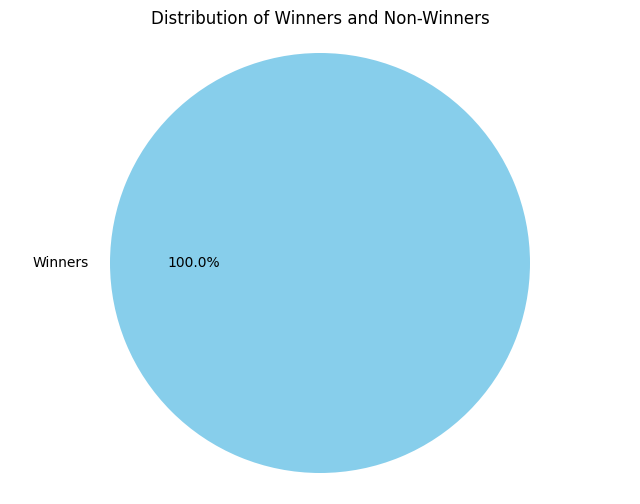

In [27]:
winner_counts = df['winner'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(winner_counts, labels=winner_counts.index.map({True: 'Winners', False: 'No Winners'}), autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Winners and Non-Winners')
plt.axis('equal')  
plt.show()

The column is renamed because when looking at a 100% winning percentage, it is suspected that it does not accurately reflect whether a nominee was actually a winner.

In [28]:
df = df.rename(columns={'winner': 'grammy_nominee'})

An additional analysis is performed to verify the number of winners by category and year, which will reveal whether the column correctly reflects the winner status. This ensures that the column name is more descriptive and accurate.

In [29]:
more_than_one_winner = df[df['grammy_nominee'] == True].groupby(['year', 'category']).size() > 1

if more_than_one_winner.any():
    print("Yes, there is more than one winner per category per year.")
else:
    print("There is no more than one winner per category per year.")

Yes, there is more than one winner per category per year.


The rationale for renaming the column lies in the discovery of multiple winners by category and year, indicating that the original column does not accurately reflect winner status. Renaming the column ensures a more adequate description of its meaning, better reflecting information about whether a nominee was actually a Grammy winner.

We verify that there are no null values left in our data set.

In [30]:
df.isnull().sum()

year              0
title             0
category          0
nominee           0
artist            0
workers           0
grammy_nominee    0
dtype: int64

In [31]:
df.to_csv('grammynew.csv', index=False)

### Transformations Performed on the Grammy Dataset

1. **Fill null values in 'artist' using 'workers' with regular expressions**:
   - Description: fills null values in the 'artist' column by extracting information from the 'workers' column using regular expressions to find text in parentheses.
   
2. **Fill null values in 'artist' with 'workers'**:
   - Description: fill the remaining null values in the 'artist' column using the values from the 'workers' column.
   
3. **Fill null values in 'workers' with 'artist'**:
   - Description: fills in the null values in the 'workers' column using the values in the 'artist' column.
   
4. **Clean the 'category' column of special characters**:
   - Description: Removes special characters (such as hyphens and parentheses) from the 'category' column using regular expressions.
   
5. **Assign 'nominee' values to 'artist' and 'workers' in categories containing 'Artist'**:
   - Description: In rows where the 'category' column contains the word 'Artist', assign 'nominee' values to the 'artist' and 'workers' columns.
   
6. **Fill null values in 'artist' with 'nominee'**:
   - Description: fills in the remaining null values in the 'artist' column using the values from the 'nominee' column.
   
     
7. **Fill null values in 'workers' with 'nominee'**:
   - Description: fills null values in the 'workers' column using the values in the 'nominee' column.

8. **Transformations in the 'winner' Column**: In this transformation, the 'winner' column is converted into binary values (0 or 1), where 1 represents that he/she was nominated for a Grammy and the column is renamed.
   
9. **Delete specific records by index**:
   - Description: Deletes records at the specified indexes (2279, 2379, 2475, 2569, 4527, 4575) from the 'grammy_df' dataset.
   
10. **Delete columns 'published_at', 'updated_at' and 'img'**:
   - Description: Removes the columns 'published_at', 'updated_at' and 'img' from the 'grammy_df' dataset.


After applying the transformations to the dataset, here is the general visualization of how it was structured.

In [32]:
df.head()

,year,title,category,nominee,artist,workers,grammy_nominee
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",True
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",True
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",True
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",True
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",True


The graph "Distribution of Grammy Nominations by Year" shows an upward trend in the number of nominations over time. This trend suggests that the Grammy Awards have become more popular over time. 

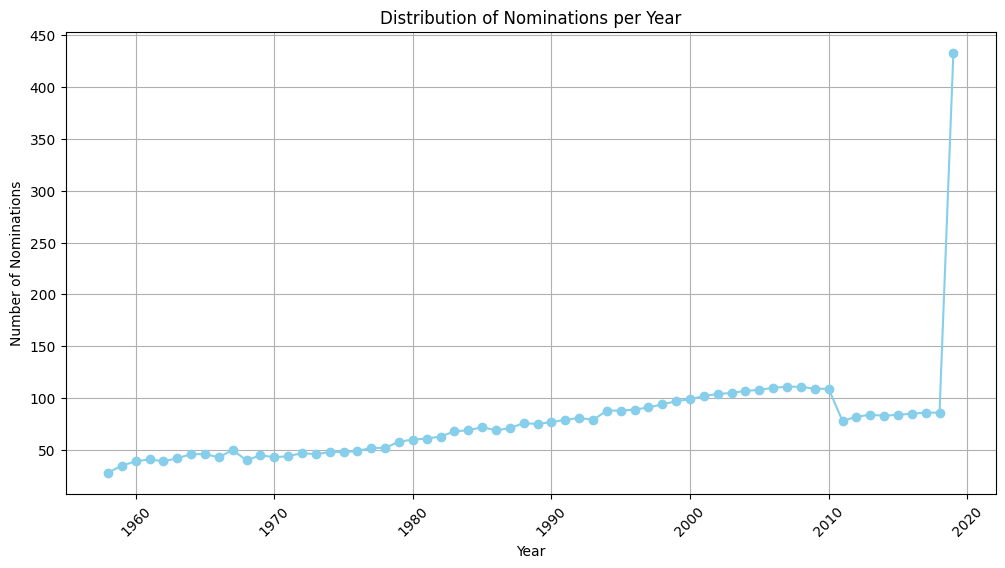

In [33]:
frequency_per_year = df['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(frequency_per_year.index, frequency_per_year.values, marker='o', linestyle='-', color='skyblue')
plt.title('Distribution of Nominations per Year')
plt.xlabel('Year')
plt.ylabel('Number of Nominations')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


An analysis of the categories with the most Grammy nominations from 1960 to 2023 shows significant data. "Song of the Year" leads with 70 nominations, followed by "Record of the Year" with 60 and "Album of the Year" with 50. These numbers reflect the importance and popularity of these categories in the music industry, highlighting the appreciation for songwriting, recording quality and full-length albums.

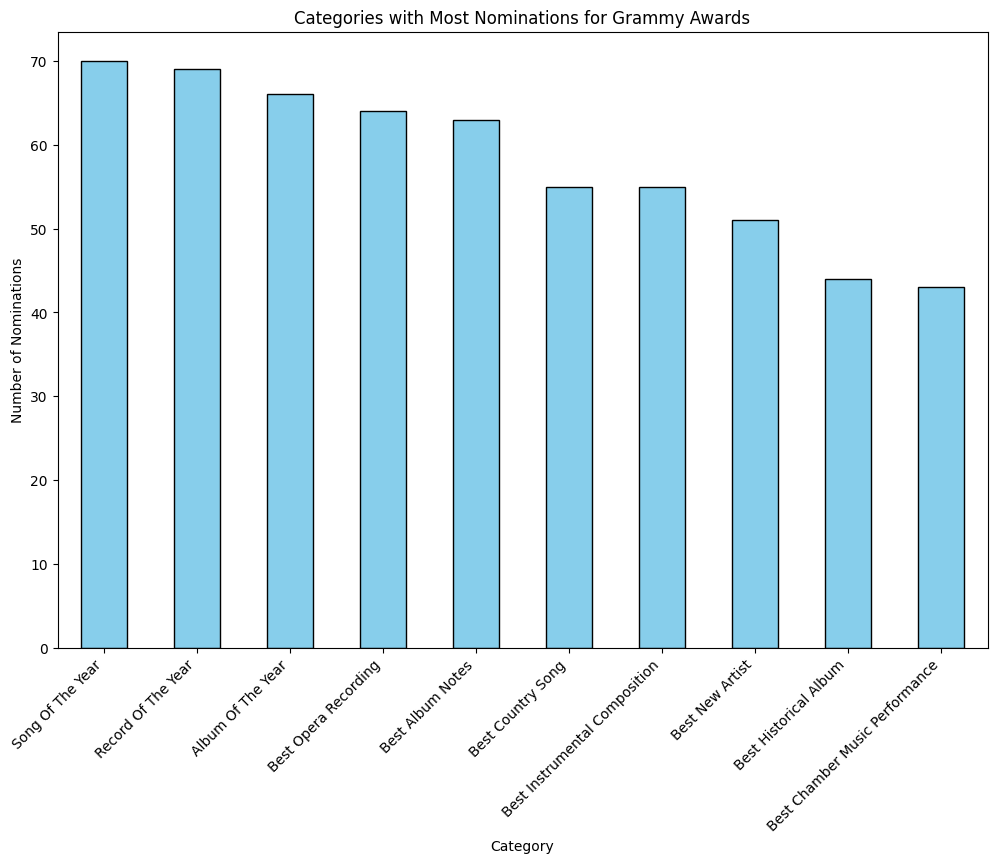

In [34]:
nominations_per_category = df['category'].value_counts()

top_nomination_categories = nominations_per_category.head(10)
plt.figure(figsize=(12, 8)) 
top_nomination_categories.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Categories with Most Nominations for Grammy Awards')
plt.xlabel('Category')
plt.ylabel('Number of Nominations')
plt.xticks(rotation=45, ha='right')

plt.show()


The graph "Number of Grammy Nominations by Year (2015-2019)" shows a downward trend in the number of nominations over time, with the exception of 2019, which shows a significant increase. This trend suggests that the Grammy nomination process has become more selective over the past five years, with the exception of 2019, which could be the result of a change in nomination rules or criteria, an increase in artist participation, or a change in voter preferences.

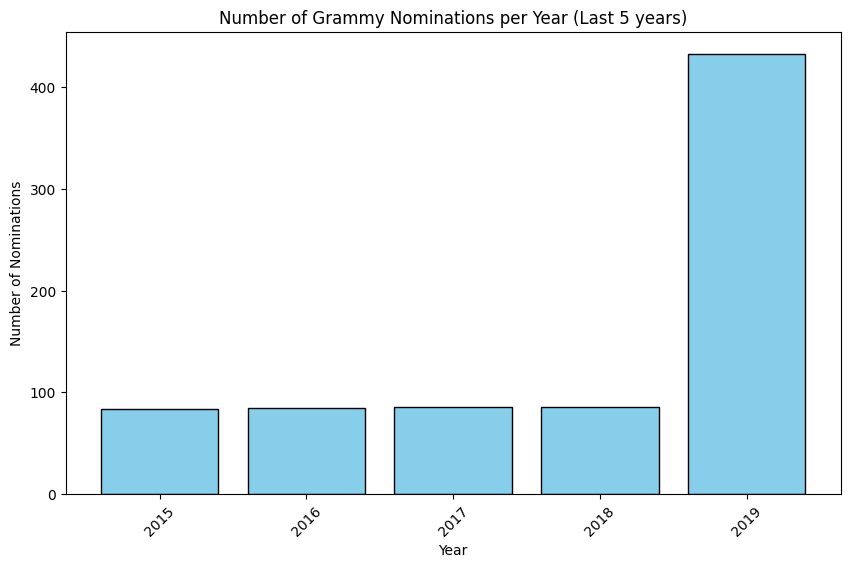

In [35]:
last_5_years = df[df['year'] >= df['year'].max() - 4]

nominations_per_year = last_5_years.groupby('year')['nominee'].count()

plt.figure(figsize=(10, 6))
plt.bar(nominations_per_year.index, nominations_per_year.values, color='skyblue', edgecolor='black')
plt.title('Number of Grammy Nominations per Year (Last 5 years)')
plt.xlabel('Year')
plt.ylabel('Number of Nominations')
plt.xticks(rotation=45)
plt.show()

In [36]:
last_5_years = df[df['year'] >= df['year'].max() - 4]

nominations_per_year = last_5_years.groupby('year')['nominee'].count().reset_index()
nominations_per_year.rename(columns={'nominee': 'Nominee'}, inplace=True)

print("Table of Nominations per Year (Last 5 years):\n")
nominations_per_year


Table of Nominations per Year (Last 5 years):



,year,Nominee
0,2015,84
1,2016,85
2,2017,86
3,2018,86
4,2019,433
